# Template Notebook for NSGA II Multi-Objective-Optimization exploring the Prompt Embedding space
Notebook Version: 0.32 (07/03/2024)
* better visualization of evolution with radar charts

## Google Colab Setup

In [ ]:
# Google Colab: Execute this to install packages and setup drive
!pip install "evolutionary[all] @ git+https://git@github.com/malthee/evolutionary-diffusion.git"

In [ ]:
# Mount drive to save results
from google.colab import drive
import evolutionary_imaging.processing as ip
drive.mount("/content/drive")
base_path = "/content/drive/MyDrive/evolutionary/"
ip.RESULTS_FOLDER = base_path + ip.RESULTS_FOLDER

In [ ]:
# Check if GPU is available
import torch
print(torch.cuda.is_available())

## Project Setup

In [1]:
from evolutionary.plotting import plot_fitness_statistics
import evolutionary_imaging.processing as ip
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_radar_chart_grid, save_images_from_generation
import torch
import os

In [2]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To remove warning of libraries using tokenizers
# Change the results folder for images if you want to 
# ip.RESULTS_FOLDER = 'choose_your_destination'

def save_images_post_sort(g, a):
    save_images_from_generation(a.fronts[0], g)  # Only save from first front
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([168,  19, 151,  ...,   0,   0,   0], dtype=torch.uint8)


In [ ]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import PooledArithmeticCrossover, PooledUniformGaussianMutator, UniformGaussianMutatorArguments
from evolutionary.evolutionary_selectors import TournamentSelector
from evolutionary.algorithms.nsga_ii import NSGA_II
from evolutionary_imaging.evaluators import AestheticsImageEvaluator, CLIPScoreEvaluator, MultiCLIPIQAEvaluator, \
    SingleCLIPIQAEvaluator
from evolutionary.evolution_base import MultiObjectiveEvaluator
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange

population_size = 50
num_generations = 100
batch_size = 1
elitism = 1
metrics = ("quality", "happy", "scary")

# Define min/max values for the prompt embeddings
embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=4)
evaluator = MultiCLIPIQAEvaluator(metrics=metrics)
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
# clamp_range was evaluated with pre-testing/clamp_range/sdxl_turbo.py
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=2, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=0.4, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments
#init_embed = creator.arguments_from_prompt(prompt) # with prompt
#init_args = [init_embed for _ in range(population_size)]
init_args = [PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range()) 
             for _ in range(population_size)] # random

nsga = NSGA_II(
    num_generations=num_generations,
    population_size=population_size,
    solution_creator=creator,
    selector=selector,
    crossover=crossover,
    mutator=mutator,
    evaluator=evaluator,
    elitism_count=elitism,
    initial_arguments=init_args,
    post_non_dominated_sort_callback=save_images_post_sort
)

In [ ]:
best_solution = nsga.run()

In [ ]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Visualize the evolution

In [ ]:
for gen in range(num_generations):
    create_generation_radar_chart_grid(gen, metrics, max_images=6)

In [ ]:
video_loc = create_animation_from_generations(num_generations)
print(video_loc)

## Plot fitness statistics (Separately)

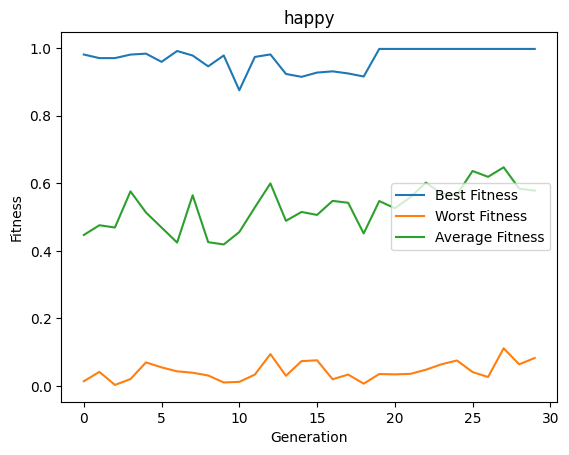

In [16]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title=metrics[1], multi_objective_plot_index=1)

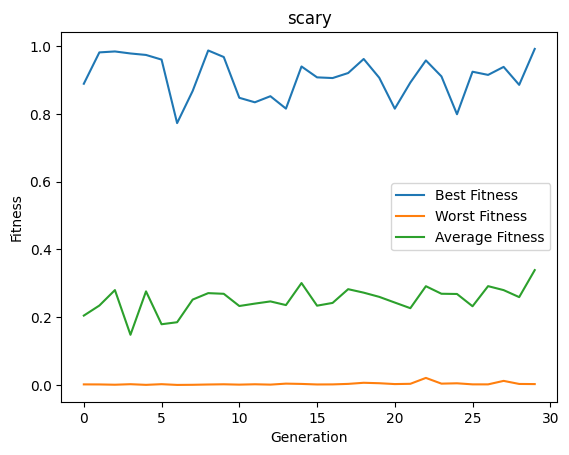

In [17]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title=metrics[2], multi_objective_plot_index=2)

## Plot fitness statistics (Together)

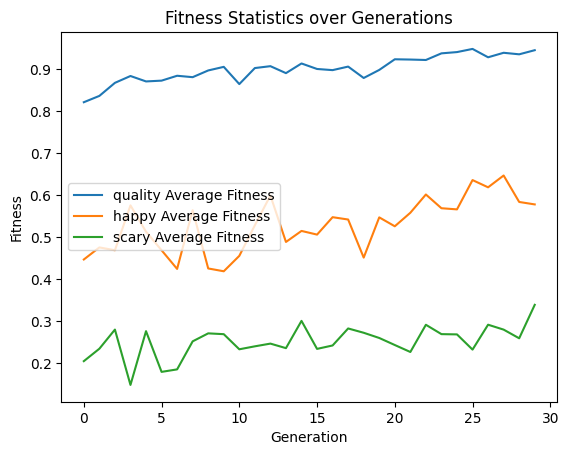

In [18]:
plot_fitness_statistics(num_generations, avg_fitness=nsga.avg_fitness, labels=metrics)

## Save notebook and components

In [ ]:
!jupyter nbconvert --to html nsga_notebook.ipynb

### Save the run to disk

In [ ]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
output_file = os.path.join("saved_runs", f"nsga_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl")
with open(output_file, "wb") as f:
    pickle.dump(nsga, f)
print(f"Run saved to {output_file}")

### Load the run from disk 
Notebook and library versions should match with the saved run

In [ ]:
import pickle
import os

with open(os.path.join("saved_runs", "insert_filename"), "rb") as f:
    nsga = pickle.load(f)

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary_imaging.processing as ip
from PIL import Image

num_generations = 4  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join("results", f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.fitness_filename_sorting_key, reverse=True)
print(image_files[0])
Image.open(image_files[0])

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary_imaging.processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)